In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from file_manager import FileManager
fm = FileManager()

In [2]:
# Pass in player dataframe
def overview(df: pd.DataFrame):
    infocols: list[str,...] = ['date', 'name', 'team', 'opp', 'starter']
    statcols: list[str,...] = [col for col in df.columns if col not in infocols]

    last10: list[str,...] = list((df
                                  .sort_values('date', ascending=False)
                                  ['date']
                                 ))[:10]
    
    last5: list[str,...] = last10[:5]
    
    # overview
    ov: dict[str,str|int|float] = {
        'name': df['name'].drop_duplicates().item(),
        'team(s)': ','.join(df['team'].drop_duplicates()),
        'played': len(df),
        'started': len(df.loc[df['starter']==1])
    }
    
    distro: pd.Series = df['fpts'].describe().round(1)
    
    ov: dict[str, str|int|float] = {
        **ov,
        **{'ceiling': distro['75%'],'floor': distro['25%']},
        **{f'med-{stat}': np.median(df[stat]).round(2) for stat in statcols},
        **{
            f'l10-median-{stat}': np.median(df.loc[df['date'].isin(last10),stat]) 
            for stat in ('fpts', 'fppm', 'mp')
        },
        **{
            f'l5-median-{stat}': np.median(df.loc[df['date'].isin(last5),stat]) 
            for stat in ('fpts', 'fppm', 'mp')
        }
    }
    
    return pd.Series(ov)

In [14]:
# Return graph of player outcomes
def view_player(name: str, **kwargs):
    
    columns: list[str,...] = [
        'date',
        'name',
        'team',
        'opp',
        'fpts',
        'mp',
        'fppm',
        'usg',
        'pts',
        'ast',
        'trb',
        'starter'
    ]
    
    stats: list[str,...] = sum([
        columns,
        kwargs.get('stats', [])
    ], [])
    
    starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else (int(kwargs['starter']),)
    
    df: pd.DataFrame = (fm
                        .load_clean_data()
                        .pipe(lambda df_: df_.loc[(df_['name'] == name)
                                                  & df_['starter'].isin(starter_)
                                                 ])
                        [stats]
                       )
    
    
    if kwargs.get('dates') is not None:
        df: pd.DataFrame = df.loc[df['date'].isin(kwargs['dates'])]
    
    ov: pd.Series = overview(df)
    bins_: int = int(ov['played']) // 1
    print(ov)
    
    plot: str = kwargs.get('plot', 'histogram')
    plotkwargs = {kw:arg for kw,arg in kwargs.items() if kw not in ('stats','target', 'starter','dates')}
    
    plotkwargs = {
        **plotkwargs,
        **{'figsize': plotkwargs.get('figsize',(15,10)), 'bins': plotkwargs.get('bins', bins_)}
    }
    
    target: str = kwargs.get('target', 'fpts')
    
    
    if plot in ('hist', 'histogram'):
        return (df
                .plot
                .hist(
                    column=[target],
                    # Nondefault args for hist
                    # bins=plotkwargs.get('bins', 7),
                    # figsize=figsize,
                    **plotkwargs
                )
               )
    
    if plot in ('box', 'boxplot'):
        return (df
                .plot
                .box(column=[target],figsize=plotkwargs['figsize'])
               )
    
    return None

In [29]:
def correlation_between(*args, **kwargs) -> float:
    stat: str = kwargs.get('stat', 'fpts')
    df: pd.DataFrame = (fm.load_clean_data()
                        .pipe(lambda df_: df_.loc[(df_['name'].isin(args))
                                                  & (df_['mp']>=12.0)
                                                  # & (df_['starter']==1)
                                                 ])
                       )
    
    if 'team' in kwargs:
        df: pd.DataFrame = df.loc[df['team'] == 'team']
    
    dates: tuple[str,...] = tuple(df
                                  .groupby('date')
                                  ['name']
                                  .agg('count')
                                  .pipe(lambda s_: s_.loc[s_== 2])
                                  .index
                                 )
    
    s0: pd.Series = (df
                     .loc[(df['name']==args[0]) 
                          & (df['date'].isin(dates))
                         ]
                     .sort_values('date')
                     .reset_index(drop=True)
                     [stat]
                     .astype('float')
                    )
    
    s1: pd.Series = (df
                     .loc[(df['name']==args[1]) 
                          & (df['date'].isin(dates))
                         ]
                     .sort_values('date')
                     .reset_index(drop=True)
                     [stat]
                     .astype('float')
                    )
    
    
    print(f'Sample size: {len(dates)}\n')
    
    return s0.corr(s1)
    # return tuple([len(s) for s in (s0,s1)])

In [37]:
correlation_between(
    'Anthony Davis',
    'Troy Brown',
    stat='mp'
)

Sample size: 36



0.42678501494041965

In [34]:
correlation_between(
    'Fred VanVleet', 
    'Gary Trent',
    stat='mp'
    # stat='fppm'
)

Sample size: 47



0.3035908076613799

In [38]:
correlation_between('Lonnie Walker', 'Rui Hachimura')

Sample size: 25



-0.15119922059834096

In [39]:
correlation_between('Troy Brown', 'Rui Hachimura')

Sample size: 31



0.07690017017707856

In [18]:
correlation_between('OG Anunoby', 'Pascal Siakam')

Sample size: 42



0.07696195281770052

In [44]:
correlation_between('Fred VanVleet', 'OG Anunoby', stat='mp')

Sample size: 40



0.4583712895838402

In [45]:
correlation_between('OG Anunoby', 'Scottie Barnes')

Sample size: 49



0.19310278641670192

In [43]:
correlation_between('Fred VanVleet', 'Gary Trent')

Sample size: 47



0.07085654829943974

name               Troy Brown
team(s)                   LAL
played                     36
started                    36
ceiling                  21.7
floor                    15.3
med-fpts                 18.5
med-mp                  27.35
med-fppm                 0.65
med-usg                  0.13
med-pts                   9.0
med-ast                   1.0
med-trb                   4.0
l10-median-fpts          22.7
l10-median-fppm      0.679056
l10-median-mp       32.216667
l5-median-fpts           26.2
l5-median-fppm       0.712219
l5-median-mp        33.416667
dtype: object


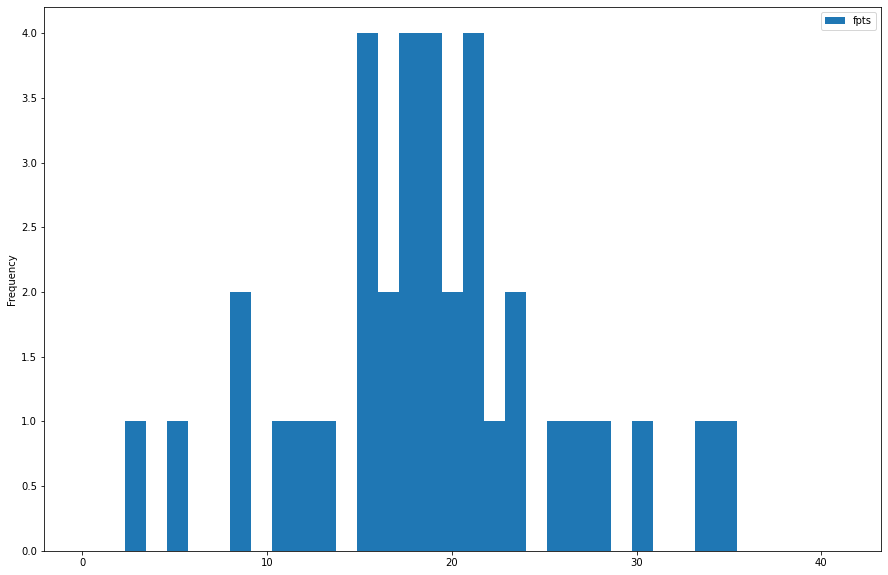

In [22]:
view_player(
    'Troy Brown',
    starter=True,
    # plot='box',
    # bins=2,
);

In [21]:
def boom_bust(name: str, salary: int, **kwargs) -> tuple[float, float]:
    starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else (int(kwargs['starter']),)
    df: pd.DataFrame = (fm
                        .load_clean_data()
                        .pipe(lambda df_: df_.loc[(df_['name'] == name)
                                                  & df_['starter'].isin(starter_)
                                                  & (df_['mp']>10.0)
                                                 ])
                        [['date', 'name', 'fpts']]
                        .set_index('name')
                       )
    

    if kwargs.get('dates') is not None:
        df: pd.DataFrame = df.loc[df['date'].isin(kwargs['dates'])]
    
    five_x: float = 5 * (salary / 1000)
    total: int = len(df)
    
    boom: int = len(df.loc[df['fpts']>=five_x+10])
    five: int = len(df.loc[(df['fpts']>=five_x) & (df['fpts']<five_x+10)])
    bust: int = len(df.loc[df['fpts']<five_x])
    
    print(f'Sample size: {total}\n')
    
    return (pd
            .Series({'boom': 100*(boom/total), 'fivex': 100*(five/total), 'bust': 100*(bust/total)})
            .round(2)
            # .plot
            # .barh(figsize=(10,5))
           )
    
    
    # return tuple([ 100*(val/total) for val in (boom, bust) ])
    
    # return df

In [17]:
boom_bust('Jaden Ivey', 6100) #, starter=True)

Sample size: 59



boom      5.08
fivex    27.12
bust     67.80
dtype: float64

In [18]:
boom_bust('Nikola Jokic', 12000)

Sample size: 56



boom     10.71
fivex    23.21
bust     66.07
dtype: float64

In [21]:
boom_bust('Marvin Bagley', 6200)

Sample size: 28



boom      7.14
fivex    25.00
bust     67.86
dtype: float64

In [25]:
boom_bust('Joel Embiid', 11800)

Sample size: 50



boom     14.0
fivex    18.0
bust     68.0
dtype: float64

In [23]:
boom_bust(
    'Grant Williams', 
    4500,
    dates=('2022-11-27', '2022-12-18', '2023-01-21', '2023-02-14')
)

Sample size: 4



boom      0.0
fivex    75.0
bust     25.0
dtype: float64

In [24]:
boom_bust(
    'Derrick White', 
    5700,
    dates=('2022-11-27', '2022-12-18', '2023-01-21', '2023-02-14')
)

Sample size: 4



boom     25.0
fivex     0.0
bust     75.0
dtype: float64

In [26]:
boom_bust('Scottie Barnes', 7800, starter=True)

boom     8.47
bust    66.10
dtype: float64

In [27]:
boom_bust('Kyle Kuzma', 7700, starter=True)

boom    12.50
bust    64.29
dtype: float64

In [28]:
boom_bust('Pascal Siakam', 9300, starter=True)

boom    18.87
bust    60.38
dtype: float64

In [32]:
boom_bust('Donte DiVincenzo', 6500, starter=True)

boom     5.88
bust    70.59
dtype: float64

In [34]:
boom_bust('Tobias Harris', 6000, starter=True)

boom    14.04
bust    54.39
dtype: float64

In [18]:
boom_bust('Kristaps Porzingis', 9100, starter=True)

boom    13.21
bust    60.38
dtype: float64

In [12]:
boom_bust('Shai Gilgeous-Alexander', 10500, starter=True)

boom    18.52
bust    59.26
dtype: float64

In [20]:
boom_bust('TJ McConnell', 4700, starter=True)

boom    50.00
bust    33.33
dtype: float64

In [13]:
boom_bust('RJ Barrett', 5900, starter=True)

boom    17.24
bust    53.45
dtype: float64

In [14]:
boom_bust('Franz Wagner', 5900, starter=True)

boom     9.52
bust    49.21
dtype: float64

In [15]:
boom_bust('Jaren Jackson', 8000, starter=True)

boom    15.56
bust    62.22
dtype: float64

In [19]:
boom_bust('Blake Wesley', 3800, starter=False)

boom     0.00
bust    91.67
dtype: float64

In [11]:
boom_bust('Kelly Olynyk', 5800, starter=True)

boom    11.54
bust    63.46
dtype: float64

In [10]:
boom_bust('Brook Lopez', 7000, starter=True)

boom    11.29
bust    61.29
dtype: float64